MODEL USED : Random Forest 

DATASET : ALL WEEKS (input_2023_w01 to w18 / output_2023_w01 to w18)

OUTPUT FRAMES PREDICTED : 15 

INPUT FRAMES NEEDED BEFORE THROW : 3 (X-2, X-1, X0) 

METHOD : SEQUENTIAL TRAINING [(...X0, X1) ---> (...X1, X2) ---> ETC] 

SEPARATE MODELS FOR X AND Y : YES 


In [1]:
import os
import re
import glob
import json
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KDTree
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load ALL input datasets (w01 to w18)
print("Loading all input datasets (w01 to w18)...")
print("="*80)

input_dfs = []
for week in range(1, 19):
    filename = f'train/input_2023_w{week:02d}.csv'
    print(f"Loading {filename}...", end=" ")
    df = pd.read_csv(filename)
    print(f"✓ Shape: {df.shape}")
    input_dfs.append(df)

# Concatenate all input dataframes
df_input = pd.concat(input_dfs, ignore_index=True)
print(f"\n✓ All input datasets loaded and merged!")
print(f"  Total shape: {df_input.shape}")
print(f"  Unique games: {df_input['game_id'].nunique()}")
print(f"  Unique players: {df_input['nfl_id'].nunique()}")

# Load ALL output datasets (w01 to w18)
print("\n" + "="*80)
print("Loading all output datasets (w01 to w18)...")
print("="*80)

output_dfs = []
for week in range(1, 19):
    filename = f'train/output_2023_w{week:02d}.csv'
    print(f"Loading {filename}...", end=" ")
    df = pd.read_csv(filename)
    print(f"✓ Shape: {df.shape}")
    output_dfs.append(df)

# Concatenate all output dataframes
df_output = pd.concat(output_dfs, ignore_index=True)
print(f"\n✓ All output datasets loaded and merged!")
print(f"  Total shape: {df_output.shape}")
print(f"  Unique games: {df_output['game_id'].nunique()}")
print(f"  Unique players: {df_output['nfl_id'].nunique()}")

print("\n" + "="*80)
print("DATA LOADING COMPLETE")
print("="*80)
print(f"df_input:  {df_input.shape}")
print(f"df_output: {df_output.shape}")

# Display sample
print("\nSample of df_input:")
df_input.head()







Loading all input datasets (w01 to w18)...
Loading train/input_2023_w01.csv... ✓ Shape: (285714, 23)
Loading train/input_2023_w02.csv... ✓ Shape: (288586, 23)
Loading train/input_2023_w03.csv... ✓ Shape: (297757, 23)
Loading train/input_2023_w04.csv... ✓ Shape: (272475, 23)
Loading train/input_2023_w05.csv... ✓ Shape: (254779, 23)
Loading train/input_2023_w06.csv... ✓ Shape: (270676, 23)
Loading train/input_2023_w07.csv... ✓ Shape: (233597, 23)
Loading train/input_2023_w08.csv... ✓ Shape: (281011, 23)
Loading train/input_2023_w09.csv... ✓ Shape: (252796, 23)
Loading train/input_2023_w10.csv... ✓ Shape: (260372, 23)
Loading train/input_2023_w11.csv... ✓ Shape: (243413, 23)
Loading train/input_2023_w12.csv... ✓ Shape: (294940, 23)
Loading train/input_2023_w13.csv... ✓ Shape: (233755, 23)
Loading train/input_2023_w14.csv... ✓ Shape: (279972, 23)
Loading train/input_2023_w15.csv... ✓ Shape: (281820, 23)
Loading train/input_2023_w16.csv... ✓ Shape: (316417, 23)
Loading train/input_2023_w17.

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [2]:
df_input_TRUE = df_input[df_input['player_to_predict'] == True]

In [3]:
df_input_TRUE = df_input_TRUE.drop(columns=["player_name"])

In [4]:
# Step 1: Keep ALL players, but for each player, keep only their last 3 input frames
print(f"Before filtering - df_input_TRUE shape: {df_input_TRUE.shape}")
print(f"Before filtering - df_output shape: {df_output.shape}")
print(f"num_frames_output distribution:\n{df_input_TRUE['num_frames_output'].value_counts().sort_index()}")

# Get the last 3 frame_ids for each player (sorted descending, take top 3)
last_3_frames = df_input_TRUE.groupby(['game_id', 'play_id', 'nfl_id']).apply(
    lambda x: x.nlargest(3, 'frame_id')[['game_id', 'play_id', 'nfl_id', 'frame_id']]
).reset_index(drop=True)

print(f"\nLast 3 frames shape: {last_3_frames.shape}")
print(f"Frames per player:\n{last_3_frames.groupby(['game_id', 'play_id', 'nfl_id']).size().value_counts()}")

# Keep only rows that match the last 3 frames for each player
df_input_TRUE = df_input_TRUE.merge(
    last_3_frames, 
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'], 
    how='inner'
)

print(f"After keeping only last 3 input frames per player: {df_input_TRUE.shape}")

# Step 2: For df_output, keep ALL players but cap output frames at 15
# If a player has more than 15 output frames, keep only frames 1-15
print(f"\n--- Processing df_output ---")
print(f"df_output frame_id range: {df_output['frame_id'].min()} to {df_output['frame_id'].max()}")

# Keep only output frames 1 through 15
df_output = df_output[df_output['frame_id'] <= 15].copy()

print(f"After capping output frames at 15: {df_output.shape}")
print(f"df_output frame_id range after filtering: {df_output['frame_id'].min()} to {df_output['frame_id'].max()}")

# Verify we have the same players in both datasets
players_in_input = set(df_input_TRUE[['game_id', 'play_id', 'nfl_id']].apply(tuple, axis=1))
players_in_output = set(df_output[['game_id', 'play_id', 'nfl_id']].apply(tuple, axis=1))

print(f"\nPlayers in df_input_TRUE: {len(players_in_input)}")
print(f"Players in df_output: {len(players_in_output)}")
print(f"Players in both: {len(players_in_input.intersection(players_in_output))}")


Before filtering - df_input_TRUE shape: (1303440, 22)
Before filtering - df_output shape: (562936, 6)
num_frames_output distribution:
num_frames_output
5       7595
6      45811
7     114964
8     144572
9     142384
10    139061
11    110066
12     93127
13     80221
14     65116
15     53207
16     46442
17     36557
18     33164
19     24743
20     23865
21     18926
22     18765
23     19289
24     15470
25     12030
26     11314
27     11889
28     10282
29     10342
30      3733
31      5091
32      1902
33      1414
34       867
36       444
40       315
55       264
94       208
Name: count, dtype: int64


C:\Users\Matteo\AppData\Local\Temp\ipykernel_1728\971827425.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_3_frames = df_input_TRUE.groupby(['game_id', 'play_id', 'nfl_id']).apply(



Last 3 frames shape: (138135, 4)
Frames per player:
3    46045
Name: count, dtype: int64
After keeping only last 3 input frames per player: (138135, 22)

--- Processing df_output ---
df_output frame_id range: 1 to 94
After capping output frames at 15: (504352, 6)
df_output frame_id range after filtering: 1 to 15

Players in df_input_TRUE: 46045
Players in df_output: 46045
Players in both: 46045


In [5]:
# Create frame numbering where 0 is the last frame, -1 is second last, -2 is third last
# Sort by frame_id within each player to ensure proper ordering
df_input_TRUE = df_input_TRUE.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
df_input_TRUE['frame_position'] = df_input_TRUE.groupby(['game_id', 'play_id', 'nfl_id']).cumcount() - 2

print(f"Frame positions per player:\n{df_input_TRUE['frame_position'].value_counts().sort_index()}")
print(f"\nSample data with frame_position (note: -2=oldest, -1=middle, 0=newest):")
print(df_input_TRUE[['game_id', 'play_id', 'nfl_id', 'frame_id', 'frame_position', 'x', 'y']].head(10))

# Pivot df_input_TRUE to wide format - one observation per player
# Grouping identifiers (everything except the variables to pivot)
id_vars = ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 
           'play_direction', 'absolute_yardline_number', 
           'player_height', 'player_weight', 'player_birth_date', 
           'player_position', 'player_side', 'player_role', 
           'num_frames_output', 'ball_land_x', 'ball_land_y']

# Create the pivot using frame_position instead of frame_id
df_wide = df_input_TRUE.pivot_table(
    index=id_vars,
    columns='frame_position',
    values=['x', 'y', 's', 'a', 'dir', 'o'],
    aggfunc='first'  # Use first in case of duplicates
).reset_index()

# Flatten the multi-level column names
# This creates column names like: x_-2, x_-1, x_0, y_-2, y_-1, y_0, etc.
# Where 0 = last frame, -1 = second last, -2 = third last
df_wide.columns = ['_'.join([str(c) for c in col]).strip('_') if col[1] != '' else col[0] 
                   for col in df_wide.columns.values]

print(f"\nOriginal shape: {df_input_TRUE.shape}")
print(f"Wide format shape: {df_wide.shape}")
print(f"\nAll columns: {df_wide.columns.tolist()}")
df_wide.head()


Frame positions per player:
frame_position
-2    46045
-1    46045
 0    46045
Name: count, dtype: int64

Sample data with frame_position (note: -2=oldest, -1=middle, 0=newest):
       game_id  play_id  nfl_id  frame_id  frame_position      x      y
6   2023090700      101   44930        24              -2  50.87  14.32
7   2023090700      101   44930        25              -1  51.65  14.25
8   2023090700      101   44930        26               0  52.43  14.14
0   2023090700      101   46137        24              -2  55.10  18.37
1   2023090700      101   46137        25              -1  55.45  18.03
2   2023090700      101   46137        26               0  55.82  17.67
3   2023090700      101   52546        24              -2  48.08  12.92
4   2023090700      101   52546        25              -1  48.06  12.70
5   2023090700      101   52546        26               0  48.01  12.44
21  2023090700      194   41325        30              -2  90.07  22.77

Original shape: (138135, 23)


,game_id,play_id,player_to_predict,nfl_id,play_direction,absolute_yardline_number,player_height,player_weight,player_birth_date,player_position,...,o_0,s_-2,s_-1,s_0,x_-2,x_-1,x_0,y_-2,y_-1,y_0
0,2023090700,101,True,44930,right,42,6-3,196,1995-02-16,WR,...,106.80,7.73,7.86,7.90,50.87,51.65,52.43,14.32,14.25,14.14
1,2023090700,101,True,46137,right,42,6-1,204,1997-02-15,SS,...,184.99,4.80,5.07,5.34,55.10,55.45,55.82,18.37,18.03,17.67
2,2023090700,101,True,52546,right,42,6-1,193,1997-01-21,CB,...,309.47,1.80,2.44,2.93,48.08,48.06,48.01,12.92,12.70,12.44
3,2023090700,194,True,41325,left,89,5-9,205,1992-05-03,RB,...,314.63,6.10,6.13,6.09,90.07,89.53,88.98,22.77,22.49,22.23
4,2023090700,194,True,44888,left,89,6-3,240,1994-09-22,OLB,...,118.10,2.14,2.64,3.14,85.29,85.32,85.35,31.77,31.52,31.23


In [6]:
# Pivot df_output to wide format
print(f"df_output shape before pivot: {df_output.shape}")
print(f"df_output columns: {df_output.columns.tolist()}")
print(f"\nSample df_output:")
print(df_output.head(10))

# Pivot output data - x and y for each future frame
df_output_wide = df_output.pivot_table(
    index=['game_id', 'play_id', 'nfl_id'],
    columns='frame_id',
    values=['x', 'y'],
    aggfunc='first'
).reset_index()

# Flatten column names - this creates x_1, x_2, ..., y_1, y_2, ...
df_output_wide.columns = ['_'.join([str(c) for c in col]).strip('_') if col[1] != '' else col[0] 
                          for col in df_output_wide.columns.values]

print(f"\ndf_output_wide shape: {df_output_wide.shape}")
print(f"Output columns: {[col for col in df_output_wide.columns if col.startswith(('x_', 'y_'))]}")

# Merge with df_wide
df_combined = df_wide.merge(
    df_output_wide,
    on=['game_id', 'play_id', 'nfl_id'],
    how='inner'
)

print(f"\nCombined shape: {df_combined.shape}")
print(f"\nAll columns: {df_combined.columns.tolist()}")

# Reorder columns to have input features first, then outputs
# Get base columns (non-pivoted)
base_cols = ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 
             'play_direction', 'absolute_yardline_number', 
             'player_height', 'player_weight', 'player_birth_date', 
             'player_position', 'player_side', 'player_role', 
             'num_frames_output', 'ball_land_x', 'ball_land_y']

# Get input frame columns (x_-2, x_-1, x_0, y_-2, y_-1, y_0, etc.)
input_cols = [col for col in df_combined.columns 
              if any(col.endswith(f'_{i}') for i in [-2, -1, 0])]

# Get output frame columns (x_1, x_2, ..., y_1, y_2, ...)
output_cols = [col for col in df_combined.columns 
               if col.startswith(('x_', 'y_')) and col not in input_cols]

# Sort to have proper order: x cols for inputs, then x cols for outputs, then y cols
x_input = sorted([col for col in input_cols if col.startswith('x_')], 
                 key=lambda x: int(x.split('_')[1]))
y_input = sorted([col for col in input_cols if col.startswith('y_')], 
                 key=lambda x: int(x.split('_')[1]))
other_input = [col for col in input_cols if not col.startswith(('x_', 'y_'))]

x_output = sorted([col for col in output_cols if col.startswith('x_')], 
                  key=lambda x: int(x.split('_')[1]))
y_output = sorted([col for col in output_cols if col.startswith('y_')], 
                  key=lambda x: int(x.split('_')[1]))

# Reorder: base + other_input + x_input + x_output + y_input + y_output
df_combined = df_combined[base_cols + other_input + x_input + x_output + y_input + y_output]

print(f"\nReordered columns: {df_combined.columns.tolist()}")
print(f"\nFinal combined dataframe:")
df_combined.head()


df_output shape before pivot: (504352, 6)
df_output columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Sample df_output:
      game_id  play_id  nfl_id  frame_id      x      y
0  2023090700      101   46137         1  56.22  17.28
1  2023090700      101   46137         2  56.63  16.88
2  2023090700      101   46137         3  57.06  16.46
3  2023090700      101   46137         4  57.48  16.02
4  2023090700      101   46137         5  57.91  15.56
5  2023090700      101   46137         6  58.34  15.10
6  2023090700      101   46137         7  58.75  14.57
7  2023090700      101   46137         8  59.14  14.01
8  2023090700      101   46137         9  59.51  13.41
9  2023090700      101   46137        10  59.86  12.80

df_output_wide shape: (46045, 33)
Output columns: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y

,game_id,play_id,player_to_predict,nfl_id,play_direction,absolute_yardline_number,player_height,player_weight,player_birth_date,player_position,...,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15
0,2023090700,101,True,44930,right,42,6-3,196,1995-02-16,WR,...,12.58,12.14,11.68,11.17,10.62,10.02,9.37,8.69,7.99,7.25
1,2023090700,101,True,46137,right,42,6-1,204,1997-02-15,SS,...,15.10,14.57,14.01,13.41,12.80,12.15,11.46,10.75,10.02,9.26
2,2023090700,101,True,52546,right,42,6-1,193,1997-01-21,CB,...,10.00,9.55,9.12,8.70,8.29,8.00,7.70,7.39,7.11,6.86
3,2023090700,194,True,41325,left,89,5-9,205,1992-05-03,RB,...,21.08,20.95,20.82,20.70,NaN,NaN,NaN,NaN,NaN,NaN
4,2023090700,194,True,44888,left,89,6-3,240,1994-09-22,OLB,...,28.57,28.04,27.50,26.97,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Standardize movement direction - make all plays go in the same direction (right)
print(f"Play direction distribution before standardization:")
print(df_combined['play_direction'].value_counts())

# Identify which columns need to be flipped for "left" plays
x_cols = [col for col in df_combined.columns if col.startswith('x_')]
y_cols = [col for col in df_combined.columns if col.startswith('y_')]
dir_cols = [col for col in df_combined.columns if col.startswith('dir_')]
o_cols = [col for col in df_combined.columns if col.startswith('o_')]

print(f"\nColumns to standardize:")
print(f"x columns: {x_cols}")
print(f"y columns: {y_cols}")
print(f"dir columns: {dir_cols}")
print(f"o columns: {o_cols}")

# Create a mask for left plays
left_mask = df_combined['play_direction'] == 'left'
print(f"\nNumber of 'left' plays: {left_mask.sum()}")
print(f"Number of 'right' plays: {(~left_mask).sum()}")

# For left plays, flip the coordinates:
# - x: flip horizontally (120 - x, assuming field is 120 yards)
# - y: flip vertically (53.3 - y, assuming field is 53.3 yards wide)
# - dir: add 180 degrees and modulo 360
# - o: add 180 degrees and modulo 360
# - s, a: keep unchanged (magnitudes don't change direction)

# Check sample values before transformation
print(f"\nSample values BEFORE standardization (left play):")
sample_left = df_combined[left_mask].iloc[0]
print(f"play_direction: {sample_left['play_direction']}")
print(f"x_0: {sample_left['x_0']}, y_0: {sample_left['y_0']}")
if 'x_1' in df_combined.columns:
    print(f"x_1: {sample_left['x_1']}, y_1: {sample_left['y_1']}")
print(f"dir_0: {sample_left['dir_0']}, o_0: {sample_left['o_0']}")

# Flip x coordinates for left plays (120 - x)
for col in x_cols:
    df_combined.loc[left_mask, col] = 120 - df_combined.loc[left_mask, col]

# Flip y coordinates for left plays (53.3 - y)
for col in y_cols:
    df_combined.loc[left_mask, col] = 53.3 - df_combined.loc[left_mask, col]

# Flip direction angles for left plays (add 180 and modulo 360)
for col in dir_cols:
    df_combined.loc[left_mask, col] = (df_combined.loc[left_mask, col] + 180) % 360

# Flip orientation angles for left plays (add 180 and modulo 360)
for col in o_cols:
    df_combined.loc[left_mask, col] = (df_combined.loc[left_mask, col] + 180) % 360

# Also flip ball_land_x and ball_land_y
df_combined.loc[left_mask, 'ball_land_x'] = 120 - df_combined.loc[left_mask, 'ball_land_x']
df_combined.loc[left_mask, 'ball_land_y'] = 53.3 - df_combined.loc[left_mask, 'ball_land_y']

# Also flip absolute_yardline_number
df_combined.loc[left_mask, 'absolute_yardline_number'] = 120 - df_combined.loc[left_mask, 'absolute_yardline_number']

print(f"\nSample values AFTER standardization (originally left play):")
sample_left_after = df_combined[left_mask].iloc[0]
print(f"play_direction (original): {sample_left['play_direction']}")
print(f"x_0: {sample_left_after['x_0']}, y_0: {sample_left_after['y_0']}")
if 'x_1' in df_combined.columns:
    print(f"x_1: {sample_left_after['x_1']}, y_1: {sample_left_after['y_1']}")
print(f"dir_0: {sample_left_after['dir_0']}, o_0: {sample_left_after['o_0']}")

print(f"\nStandardization complete! All plays now oriented in the same direction.")
print(f"Shape: {df_combined.shape}")
df_combined.head()


Play direction distribution before standardization:
play_direction
right    23208
left     22837
Name: count, dtype: int64

Columns to standardize:
x columns: ['x_-2', 'x_-1', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15']
y columns: ['y_-2', 'y_-1', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15']
dir columns: ['dir_-2', 'dir_-1', 'dir_0']
o columns: ['o_-2', 'o_-1', 'o_0']

Number of 'left' plays: 22837
Number of 'right' plays: 23208

Sample values BEFORE standardization (left play):
play_direction: left
x_0: 88.98, y_0: 22.23
x_1: 88.43, y_1: 21.99
dir_0: 245.74, o_0: 314.63

Sample values AFTER standardization (originally left play):
play_direction (original): left
x_0: 31.019999999999996, y_0: 31.069999999999997
x_1: 31.569999999999993, y_1: 31.31
dir_0: 65.74000000000001, o_0: 134.63

Standardization complete! All plays now oriented in the sa

,game_id,play_id,player_to_predict,nfl_id,play_direction,absolute_yardline_number,player_height,player_weight,player_birth_date,player_position,...,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15
0,2023090700,101,True,44930,right,42,6-3,196,1995-02-16,WR,...,12.58,12.14,11.68,11.17,10.62,10.02,9.37,8.69,7.99,7.25
1,2023090700,101,True,46137,right,42,6-1,204,1997-02-15,SS,...,15.10,14.57,14.01,13.41,12.80,12.15,11.46,10.75,10.02,9.26
2,2023090700,101,True,52546,right,42,6-1,193,1997-01-21,CB,...,10.00,9.55,9.12,8.70,8.29,8.00,7.70,7.39,7.11,6.86
3,2023090700,194,True,41325,left,31,5-9,205,1992-05-03,RB,...,32.22,32.35,32.48,32.60,NaN,NaN,NaN,NaN,NaN,NaN
4,2023090700,194,True,44888,left,31,6-3,240,1994-09-22,OLB,...,24.73,25.26,25.80,26.33,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert player height from feet-inches to centimeters
print("Converting player height to centimeters...")
print(f"Sample heights before conversion: {df_combined['player_height'].head(10).tolist()}")

def height_to_cm(height_str):
    """Convert height from 'feet-inches' format to centimeters"""
    if pd.isna(height_str):
        return np.nan
    
    try:
        feet, inches = height_str.split('-')
        feet = int(feet)
        inches = int(inches)
        
        # Convert to centimeters: 1 foot = 30.48 cm, 1 inch = 2.54 cm
        cm = (feet * 30.48) + (inches * 2.54)
        return round(cm, 2)
    except:
        return np.nan

df_combined['player_height_cm'] = df_combined['player_height'].apply(height_to_cm)
print(f"\nSample heights after conversion (cm): {df_combined['player_height_cm'].head(10).tolist()}")

# Drop the original height column
df_combined = df_combined.drop(columns=['player_height'])

# Convert player birth date to age in years
print("\n\nConverting birth date to age...")
print(f"Sample birth dates: {df_combined['player_birth_date'].head(10).tolist()}")

# Extract game date from game_id (format: YYYYMMDD##)
# game_id like 2023090700 -> year=2023, month=09, day=07
def extract_game_date(game_id):
    """Extract date from game_id"""
    game_id_str = str(game_id)
    year = int(game_id_str[0:4])
    month = int(game_id_str[4:6])
    day = int(game_id_str[6:8])
    return pd.Timestamp(year=year, month=month, day=day)

# Get game dates
df_combined['game_date'] = df_combined['game_id'].apply(extract_game_date)

# Convert birth_date to datetime
df_combined['player_birth_date'] = pd.to_datetime(df_combined['player_birth_date'])

# Calculate age at time of game
df_combined['player_age'] = (df_combined['game_date'] - df_combined['player_birth_date']).dt.days / 365.25

# Round to 2 decimal places
df_combined['player_age'] = df_combined['player_age'].round(2)

print(f"\nSample ages: {df_combined['player_age'].head(10).tolist()}")
print(f"Age statistics:\n{df_combined['player_age'].describe()}")

# Drop temporary columns
df_combined = df_combined.drop(columns=['player_birth_date', 'game_date'])

print(f"\nConversions complete!")
print(f"Shape: {df_combined.shape}")
print(f"\nUpdated columns (first 25): {df_combined.columns[:25].tolist()}")
df_combined.head()


Converting player height to centimeters...
Sample heights before conversion: ['6-3', '6-1', '6-1', '5-9', '6-3', '5-11', '5-11', '6-0', '6-3', '6-4']

Sample heights after conversion (cm): [190.5, 185.42, 185.42, 175.26, 190.5, 180.34, 180.34, 182.88, 190.5, 193.04]


Converting birth date to age...
Sample birth dates: ['1995-02-16', '1997-02-15', '1997-01-21', '1992-05-03', '1994-09-22', '1997-09-26', '1999-03-29', '2001-10-22', '1994-09-22', '1999-04-30']

Sample ages: [28.56, 26.56, 26.63, 31.35, 28.96, 25.95, 24.44, 21.88, 28.96, 24.36]
Age statistics:
count    46045.000000
mean        26.521840
std          2.833395
min         21.020000
25%         24.360000
50%         26.170000
75%         28.300000
max         39.600000
Name: player_age, dtype: float64

Conversions complete!
Shape: (46045, 63)

Updated columns (first 25): ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'play_direction', 'absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'playe

,game_id,play_id,player_to_predict,nfl_id,play_direction,absolute_yardline_number,player_weight,player_position,player_side,player_role,...,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,player_height_cm,player_age
0,2023090700,101,True,44930,right,42,196,WR,Offense,Targeted Receiver,...,11.68,11.17,10.62,10.02,9.37,8.69,7.99,7.25,190.50,28.56
1,2023090700,101,True,46137,right,42,204,SS,Defense,Defensive Coverage,...,14.01,13.41,12.80,12.15,11.46,10.75,10.02,9.26,185.42,26.56
2,2023090700,101,True,52546,right,42,193,CB,Defense,Defensive Coverage,...,9.12,8.70,8.29,8.00,7.70,7.39,7.11,6.86,185.42,26.63
3,2023090700,194,True,41325,left,31,205,RB,Offense,Targeted Receiver,...,32.48,32.60,NaN,NaN,NaN,NaN,NaN,NaN,175.26,31.35
4,2023090700,194,True,44888,left,31,240,OLB,Defense,Defensive Coverage,...,25.80,26.33,NaN,NaN,NaN,NaN,NaN,NaN,190.50,28.96


In [9]:
"""
================================================================================
TRAIN/TEST SPLIT STRATEGY
================================================================================

CRITICAL: We split by game_id to prevent data leakage
- All players from a game stay together (either train or test)
- This ensures no information about a test game appears in training

SPLIT RATIO: 80/20 (4/5 for training, 1/5 for testing)

NEXT STEPS:
- df_combined will be split into train and test portions
- Train portion → df_ready (with column cleaning)
- Test portion → detailed split for proper evaluation (next cell)
================================================================================
"""

# Split data: 1/5 for test, 4/5 for training (based on game_id)
print(f"Original df_combined shape: {df_combined.shape}")
print(f"Unique game_ids: {df_combined['game_id'].nunique()}")

# Get unique game_ids
unique_games = df_combined['game_id'].unique()
print(f"\nTotal unique games: {len(unique_games)}")

# Sample 1/5 of game_ids for test set
np.random.seed(42)  # For reproducibility
n_test_games = int(len(unique_games) * 0.2)  # 1/5 = 20%
test_games = np.random.choice(unique_games, size=n_test_games, replace=False)

print(f"Number of games in test set: {len(test_games)}")
print(f"Number of games in training set: {len(unique_games) - len(test_games)}")

# Split the data - keep test data with ALL information for now
df_test_full = df_combined[df_combined['game_id'].isin(test_games)].copy()
df_train_full = df_combined[~df_combined['game_id'].isin(test_games)].copy()

# Verify no overlap BEFORE dropping columns
assert len(set(df_test_full['game_id']).intersection(set(df_train_full['game_id']))) == 0, "Error: Overlap between test and training game_ids!"
print("\n✓ Verified: No overlap between test and training game_ids")
print(f"Test set games: {sorted(df_test_full['game_id'].unique())}")

# For training: remove identifier columns and unnecessary metadata to create df_ready
# CRITICAL: game_id, play_id, nfl_id are identifiers, NOT features!
# Training a model with these would cause overfitting to specific games/plays/players
columns_to_remove = ['game_id', 'play_id', 'nfl_id', 'player_to_predict', 
                     'play_direction', 'num_frames_output', 'ball_land_x', 'ball_land_y']
df_ready = df_train_full.drop(columns=columns_to_remove)

print(f"\nAfter split and column removal:")
print(f"df_test_full shape: {df_test_full.shape} (keeps ALL columns for proper evaluation)")
print(f"df_ready shape: {df_ready.shape} (training data, removed {len(columns_to_remove)} columns)")

# Encode categorical variables for LightGBM
print(f"\n--- Encoding categorical variables ---")
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['player_position', 'player_side', 'player_role']

# Check what we have
print(f"Checking categorical columns in df_ready:")
for col in categorical_cols:
    if col in df_ready.columns:
        print(f"  {col}: dtype={df_ready[col].dtype}, unique values={df_ready[col].nunique()}")

# Store encoders for later use on test data
encoders = {}

for col in categorical_cols:
    if col in df_ready.columns:
        le = LabelEncoder()
        df_ready[col] = le.fit_transform(df_ready[col].astype(str))
        encoders[col] = le
        print(f"  ✓ Encoded {col}: {len(le.classes_)} unique categories")

print(f"\ndf_ready after encoding:")
print(f"  Shape: {df_ready.shape}")
print(f"  Data types:")
print(df_ready.dtypes)


Original df_combined shape: (46045, 63)
Unique game_ids: 272

Total unique games: 272
Number of games in test set: 54
Number of games in training set: 218

✓ Verified: No overlap between test and training game_ids
Test set games: [np.int64(2023091005), np.int64(2023091008), np.int64(2023091100), np.int64(2023091702), np.int64(2023091705), np.int64(2023091707), np.int64(2023091708), np.int64(2023091800), np.int64(2023092409), np.int64(2023092412), np.int64(2023092500), np.int64(2023100111), np.int64(2023100802), np.int64(2023100803), np.int64(2023100900), np.int64(2023101500), np.int64(2023101503), np.int64(2023101511), np.int64(2023101900), np.int64(2023102210), np.int64(2023102902), np.int64(2023102906), np.int64(2023102909), np.int64(2023102911), np.int64(2023102912), np.int64(2023102913), np.int64(2023110502), np.int64(2023110504), np.int64(2023111200), np.int64(2023111207), np.int64(2023111209), np.int64(2023111901), np.int64(2023111907), np.int64(2023112301), np.int64(2023113000),

In [10]:
"""
================================================================================
PROPER TEST SET PREPARATION FOR MODEL EVALUATION
================================================================================

THE PROBLEM:
When we train sequential models to predict x_1, x_2, ..., x_15 and y_1, ..., y_15,
we need to evaluate them properly. But not all players have all 15 output frames!

EXAMPLE SCENARIO:
- Player A has 3 output frames → We can only evaluate predictions for frames 1-3
- Player B has 15 output frames → We can evaluate all predictions for frames 1-15
- Player C has 10 output frames → We can only evaluate predictions for frames 1-10

THE SOLUTION:
We create THREE dataframes from df_test_full:

1. df_test_informative:
   - Keeps: game_id, play_id, nfl_id, num_frames_output
   - Purpose: Track which player has how many actual output frames
   - This is ESSENTIAL for meaningful evaluation

2. df_test_y_true:
   - Keeps: x_1 through x_15, y_1 through y_15 (the actual observed values)
   - Purpose: The ground truth for comparing predictions
   - NA values indicate frames that were not observed for that player

3. df_test_X:
   - Keeps: Only input features (x_-2, x_-1, x_0, y_-2, y_-1, y_0, etc.)
   - Removes: Output frames AND metadata columns
   - Purpose: This is what we feed into the model for prediction

EVALUATION WORKFLOW:
1. Feed df_test_X into trained models → get predictions
2. Compare predictions with df_test_y_true
3. Use df_test_informative to know how many frames to compare for each player
4. Only evaluate frames that actually exist (using num_frames_output)

CRITICAL: The index alignment across all three dataframes allows us to match:
- Predictions (from df_test_X)
- Ground truth (from df_test_y_true)  
- Player metadata (from df_test_informative)

================================================================================
"""

print("Preparing test dataset for proper model evaluation...")
print("="*80)

# Start with df_test_full (has all columns including output frames)
df_test_informative = df_test_full.copy()

print(f"df_test_full shape: {df_test_full.shape}")
print(f"Columns in df_test_full: {df_test_full.columns.tolist()}")

# 1. Create df_test_informative: Keep only player identification and num_frames_output
info_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
df_test_informative = df_test_full[info_cols].copy()

print(f"\n1. df_test_informative created:")
print(f"   Shape: {df_test_informative.shape}")
print(f"   Columns: {df_test_informative.columns.tolist()}")
print(f"   Distribution of num_frames_output:")
print(df_test_informative['num_frames_output'].value_counts().sort_index())

# 2. Create df_test_y_true: Keep only the output frames (x_1:x_15, y_1:y_15)
output_cols = [f'x_{i}' for i in range(1, 16)] + [f'y_{i}' for i in range(1, 16)]
# Only keep columns that exist
output_cols = [col for col in output_cols if col in df_test_full.columns]
df_test_y_true = df_test_full[output_cols].copy()

print(f"\n2. df_test_y_true created:")
print(f"   Shape: {df_test_y_true.shape}")
print(f"   Columns: {df_test_y_true.columns.tolist()}")
print(f"   NA counts per output frame:")
for col in output_cols[:5]:  # Show first 5 as example
    print(f"   {col}: {df_test_y_true[col].isna().sum()} NAs")

# 3. Create df_test_X: Remove output frames AND metadata columns
cols_to_remove = output_cols + ['game_id', 'play_id', 'nfl_id', 'player_to_predict', 
                                 'play_direction', 'num_frames_output', 'ball_land_x', 'ball_land_y']
# Only remove columns that exist
cols_to_remove = [col for col in cols_to_remove if col in df_test_full.columns]
df_test_X = df_test_full.drop(columns=cols_to_remove)

print(f"\n3. df_test_X created:")
print(f"   Shape: {df_test_X.shape}")
print(f"   Columns: {df_test_X.columns.tolist()}")
print(f"   Removed {len(cols_to_remove)} columns")

# Encode categorical variables using the same encoders from training
print(f"\n   Encoding categorical variables in test data...")
for col in categorical_cols:
    if col in df_test_X.columns and col in encoders:
        # Handle unseen categories by assigning them to -1
        df_test_X[col] = df_test_X[col].astype(str)
        df_test_X[col] = df_test_X[col].apply(
            lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
        )
        print(f"      ✓ Encoded {col}")

print(f"\n   df_test_X data types after encoding:")
print(df_test_X.dtypes)

# Verify index alignment
assert len(df_test_informative) == len(df_test_y_true) == len(df_test_X), "Index mismatch!"
print(f"\n✓ Verified: All three dataframes have matching indices ({len(df_test_X)} rows)")

# Summary
print("\n" + "="*80)
print("TEST SET PREPARATION COMPLETE")
print("="*80)
print(f"df_test_informative: {df_test_informative.shape} - Player metadata")
print(f"df_test_y_true: {df_test_y_true.shape} - Actual output frames (ground truth)")
print(f"df_test_X: {df_test_X.shape} - Input features for prediction")
print("\n✓ Ready for model evaluation with proper frame-level validation")


Preparing test dataset for proper model evaluation...
df_test_full shape: (9217, 63)
Columns in df_test_full: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'play_direction', 'absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'player_role', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'a_-2', 'a_-1', 'a_0', 'dir_-2', 'dir_-1', 'dir_0', 'o_-2', 'o_-1', 'o_0', 's_-2', 's_-1', 's_0', 'x_-2', 'x_-1', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'y_-2', 'y_-1', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'player_height_cm', 'player_age']

1. df_test_informative created:
   Shape: (9217, 4)
   Columns: ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
   Distribution of num_frames_output:
num_frames_output
5       49
6      349
7      872
8     1147
9     1083
10    1047
11     791
12     588
13     572

In [11]:
"""
================================================================================
BLOCK EXPLANATION: SEQUENTIAL PREDICTION SETUP FOR TRAJECTORY FORECASTING
================================================================================

GOAL: Create 30 separate training datasets for predicting future player positions

STRATEGY: Sequential/Autoregressive Prediction
- We predict each future position step-by-step
- Each prediction uses the previous predictions as additional features
- This allows models to learn from their own trajectory progression

WHAT THIS BLOCK CREATES:
1. For X-coordinates: 15 datasets (df_train_x_1 through df_train_x_15)
2. For Y-coordinates: 15 datasets (df_train_y_1 through df_train_y_15)
3. Total: 30 training sets + 30 target vectors

HOW IT WORKS - Example with X-coordinates:

├─ df_train_x_1 (predicting x_1):
│  Features: Base features only (x_-2, x_-1, x_0, y_-2, y_-1, y_0, etc.)
│  Target: y_x_1 (the actual x_1 value)
│  Filters: Only players with valid x_1
│
├─ df_train_x_2 (predicting x_2):
│  Features: Base features + x_1 (predicted in previous step)
│  Target: y_x_2 (the actual x_2 value)
│  Filters: Only players with valid x_1 AND x_2
│
├─ df_train_x_3 (predicting x_3):
│  Features: Base features + x_1 + x_2 (previous predictions)
│  Target: y_x_3 (the actual x_3 value)
│  Filters: Only players with valid x_1, x_2, AND x_3
│
└─ ... continues through x_15

KEY INSIGHT:
- As we go further into the future (x_1 → x_15), we have MORE features
- But we also have FEWER training examples (more NAs in later frames)
- Each model builds on predictions from previous steps

SAME LOGIC APPLIES TO Y-COORDINATES (df_train_y_1 through df_train_y_15)

OUTPUTS:
- train_x_dfs: Dictionary with keys 1-15, values are DataFrames
- y_x_targets: Dictionary with keys 1-15, values are Series (targets)
- train_y_dfs: Dictionary with keys 1-15, values are DataFrames
- y_y_targets: Dictionary with keys 1-15, values are Series (targets)

================================================================================
"""

# Create all training datasets for x_1 to x_15 and y_1 to y_15
print("Creating all training datasets systematically...")
print("="*80)

# Get base features (everything except x_1:x_15 and y_1:y_15)
all_cols = df_ready.columns.tolist()
x_output_cols = [f'x_{i}' for i in range(1, 16)]
y_output_cols = [f'y_{i}' for i in range(1, 16)]
base_features = [col for col in all_cols if col not in x_output_cols + y_output_cols]

print(f"Base features: {base_features}")
print(f"\nTotal base features: {len(base_features)}")

# Dictionaries to store all dataframes and targets
train_x_dfs = {}
train_y_dfs = {}
y_x_targets = {}
y_y_targets = {}

# Create training sets for x_1 to x_15
print("\n" + "="*80)
print("Creating X training sets...")
print("="*80)

for i in range(1, 16):
    print(f"\nCreating df_train_x_{i} and y_x_{i}...")
    
    # Filter: must have valid x_1, x_2, ..., x_i
    valid_mask = df_ready[[f'x_{j}' for j in range(1, i+1)]].notna().all(axis=1)
    df_valid = df_ready[valid_mask].copy()
    
    print(f"  Rows with valid x_1 to x_{i}: {len(df_valid)} / {len(df_ready)}")
    
    # Target: x_i
    y_x_targets[i] = df_valid[f'x_{i}'].copy()
    
    # Features: base + x_1 to x_(i-1)
    if i == 1:
        # For x_1, only use base features
        feature_cols = base_features
    else:
        # For x_i (i>1), use base features + x_1 to x_(i-1)
        prev_x_cols = [f'x_{j}' for j in range(1, i)]
        feature_cols = base_features + prev_x_cols
    
    train_x_dfs[i] = df_valid[feature_cols].copy()
    
    print(f"  df_train_x_{i} shape: {train_x_dfs[i].shape}")
    print(f"  y_x_{i} shape: {y_x_targets[i].shape}")
    print(f"  Features: {len(feature_cols)} ({len(base_features)} base + {i-1} previous x)")

# Create training sets for y_1 to y_15
print("\n" + "="*80)
print("Creating Y training sets...")
print("="*80)

for i in range(1, 16):
    print(f"\nCreating df_train_y_{i} and y_y_{i}...")
    
    # Filter: must have valid y_1, y_2, ..., y_i
    valid_mask = df_ready[[f'y_{j}' for j in range(1, i+1)]].notna().all(axis=1)
    df_valid = df_ready[valid_mask].copy()
    
    print(f"  Rows with valid y_1 to y_{i}: {len(df_valid)} / {len(df_ready)}")
    
    # Target: y_i
    y_y_targets[i] = df_valid[f'y_{i}'].copy()
    
    # Features: base + y_1 to y_(i-1)
    if i == 1:
        # For y_1, only use base features
        feature_cols = base_features
    else:
        # For y_i (i>1), use base features + y_1 to y_(i-1)
        prev_y_cols = [f'y_{j}' for j in range(1, i)]
        feature_cols = base_features + prev_y_cols
    
    train_y_dfs[i] = df_valid[feature_cols].copy()
    
    print(f"  df_train_y_{i} shape: {train_y_dfs[i].shape}")
    print(f"  y_y_{i} shape: {y_y_targets[i].shape}")
    print(f"  Features: {len(feature_cols)} ({len(base_features)} base + {i-1} previous y)")

# Summary
print("\n" + "="*80)
print("SUMMARY - All datasets created successfully!")
print("="*80)

print("\nX Training Sets:")
for i in range(1, 16):
    print(f"  df_train_x_{i}: {train_x_dfs[i].shape}, y_x_{i}: {y_x_targets[i].shape}")

print("\nY Training Sets:")
for i in range(1, 16):
    print(f"  df_train_y_{i}: {train_y_dfs[i].shape}, y_y_{i}: {y_y_targets[i].shape}")

print(f"\nTotal datasets created: {len(train_x_dfs) + len(train_y_dfs)} training sets")
print(f"Total target vectors created: {len(y_x_targets) + len(y_y_targets)} targets")

# Update the individual variables for easy access
df_train_x_1 = train_x_dfs[1]
df_train_y_1 = train_y_dfs[1]
y_x_1 = y_x_targets[1]
y_y_1 = y_y_targets[1]

print("\n✓ Individual variables updated: df_train_x_1, df_train_y_1, y_x_1, y_y_1")


Creating all training datasets systematically...
Base features: ['absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'player_role', 'a_-2', 'a_-1', 'a_0', 'dir_-2', 'dir_-1', 'dir_0', 'o_-2', 'o_-1', 'o_0', 's_-2', 's_-1', 's_0', 'x_-2', 'x_-1', 'x_0', 'y_-2', 'y_-1', 'y_0', 'player_height_cm', 'player_age']

Total base features: 25

Creating X training sets...

Creating df_train_x_1 and y_x_1...
  Rows with valid x_1 to x_1: 36828 / 36828
  df_train_x_1 shape: (36828, 25)
  y_x_1 shape: (36828,)
  Features: 25 (25 base + 0 previous x)

Creating df_train_x_2 and y_x_2...
  Rows with valid x_1 to x_2: 36828 / 36828
  df_train_x_2 shape: (36828, 26)
  y_x_2 shape: (36828,)
  Features: 26 (25 base + 1 previous x)

Creating df_train_x_3 and y_x_3...
  Rows with valid x_1 to x_3: 36828 / 36828
  df_train_x_3 shape: (36828, 27)
  y_x_3 shape: (36828,)
  Features: 27 (25 base + 2 previous x)

Creating df_train_x_4 and y_x_4...
  Rows with valid x_1 to x_4: 36828 / 3

In [12]:
# Visual inspection of the 4 dictionaries
print("="*80)
print("INSPECTING THE 4 DICTIONARIES")
print("="*80)

# 1. DICTIONARY STRUCTURE - Overview
print("\n1. DICTIONARY STRUCTURE - Keys and Types")
print("-"*80)
print(f"train_x_dfs keys: {list(train_x_dfs.keys())}")
print(f"train_x_dfs type: {type(train_x_dfs)}")
print(f"Number of entries: {len(train_x_dfs)}")

print(f"\ny_x_targets keys: {list(y_x_targets.keys())}")
print(f"y_x_targets type: {type(y_x_targets)}")
print(f"Number of entries: {len(y_x_targets)}")

print(f"\ntrain_y_dfs keys: {list(train_y_dfs.keys())}")
print(f"train_y_dfs type: {type(train_y_dfs)}")
print(f"Number of entries: {len(train_y_dfs)}")

print(f"\ny_y_targets keys: {list(y_y_targets.keys())}")
print(f"y_y_targets type: {type(y_y_targets)}")
print(f"Number of entries: {len(y_y_targets)}")

# 2. INSPECT FIRST FEW ENTRIES - X predictions
print("\n\n2. INSPECTING X PREDICTIONS - First 3 Datasets")
print("="*80)

for i in [1, 2, 3]:
    print(f"\n{'='*80}")
    print(f"DATASET {i}: Predicting x_{i}")
    print(f"{'='*80}")
    
    df = train_x_dfs[i]
    target = y_x_targets[i]
    
    print(f"\ntrain_x_dfs[{i}]:")
    print(f"  Type: {type(df)}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns ({len(df.columns)}): {df.columns.tolist()}")
    print(f"\n  First 3 rows:")
    print(df.head(3))
    
    print(f"\ny_x_targets[{i}]:")
    print(f"  Type: {type(target)}")
    print(f"  Shape: {target.shape}")
    print(f"  Name: {target.name if hasattr(target, 'name') else 'N/A'}")
    print(f"  First 5 values: {target.head().tolist()}")
    print(f"  Statistics: min={target.min():.2f}, max={target.max():.2f}, mean={target.mean():.2f}, std={target.std():.2f}")
    
    # Verify index alignment
    print(f"\n  ✓ Index alignment check: {df.index.equals(target.index)}")

# 3. INSPECT MIDDLE AND LATE ENTRIES - X predictions
print("\n\n3. INSPECTING X PREDICTIONS - Middle (x_7) and Late (x_15) Datasets")
print("="*80)

for i in [7, 15]:
    print(f"\n{'='*80}")
    print(f"DATASET {i}: Predicting x_{i}")
    print(f"{'='*80}")
    
    df = train_x_dfs[i]
    target = y_x_targets[i]
    
    print(f"\ntrain_x_dfs[{i}]:")
    print(f"  Shape: {df.shape}")
    print(f"  Number of features: {len(df.columns)}")
    
    # Identify which previous x values are included
    x_features = [col for col in df.columns if col.startswith('x_')]
    print(f"  Previous x predictions included: {x_features}")
    
    print(f"\n  Sample row (first row):")
    print(df.iloc[0])
    
    print(f"\ny_x_targets[{i}]:")
    print(f"  Shape: {target.shape}")
    print(f"  Statistics: min={target.min():.2f}, max={target.max():.2f}, mean={target.mean():.2f}")

# 4. COMPARE Y PREDICTIONS - Show pattern is the same
print("\n\n4. INSPECTING Y PREDICTIONS - Sample Datasets")
print("="*80)

for i in [1, 5, 10]:
    print(f"\n{'='*80}")
    print(f"DATASET {i}: Predicting y_{i}")
    print(f"{'='*80}")
    
    df = train_y_dfs[i]
    target = y_y_targets[i]
    
    print(f"\ntrain_y_dfs[{i}]:")
    print(f"  Shape: {df.shape}")
    
    # Identify which previous y values are included
    y_features = [col for col in df.columns if col.startswith('y_') and col not in ['y_-2', 'y_-1', 'y_0']]
    print(f"  Previous y predictions included: {y_features if y_features else 'None (only base features)'}")
    
    print(f"\ny_y_targets[{i}]:")
    print(f"  Shape: {target.shape}")
    print(f"  Statistics: min={target.min():.2f}, max={target.max():.2f}, mean={target.mean():.2f}")

# 5. SUMMARY COMPARISON
print("\n\n5. SUMMARY - Feature Count Progression")
print("="*80)
print("\nX Predictions Feature Count:")
for i in range(1, 16):
    print(f"  df_train_x_{i}: {train_x_dfs[i].shape[1]} features, {train_x_dfs[i].shape[0]} samples")

print("\nY Predictions Feature Count:")
for i in range(1, 16):
    print(f"  df_train_y_{i}: {train_y_dfs[i].shape[1]} features, {train_y_dfs[i].shape[0]} samples")

print("\n" + "="*80)
print("INSPECTION COMPLETE")
print("="*80)


INSPECTING THE 4 DICTIONARIES

1. DICTIONARY STRUCTURE - Keys and Types
--------------------------------------------------------------------------------
train_x_dfs keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_x_dfs type: <class 'dict'>
Number of entries: 15

y_x_targets keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_x_targets type: <class 'dict'>
Number of entries: 15

train_y_dfs keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_y_dfs type: <class 'dict'>
Number of entries: 15

y_y_targets keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_y_targets type: <class 'dict'>
Number of entries: 15


2. INSPECTING X PREDICTIONS - First 3 Datasets

DATASET 1: Predicting x_1

train_x_dfs[1]:
  Type: <class 'pandas.core.frame.DataFrame'>
  Shape: (36828, 25)
  Columns (25): ['absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'player_role', 'a_-2', 'a_-1', 'a_0', 'dir_-2', 'dir_-1', 'dir_0', 'o_-2', 'o_-1', 'o_0'

In [13]:
"""
================================================================================
TRAINING 30 SEQUENTIAL MODELS FOR TRAJECTORY PREDICTION
================================================================================

TRAINING STRATEGY:
1. For each x_i (i=1 to 15):
   - Start with train_x_dfs[i] (has base features + x_1 to x_(i-1) placeholders)
   - For i > 1: Replace x_(i-1) column with TRUE values from y_x_targets[i-1]
   - Train model on augmented features to predict y_x_targets[i]
   
2. Same process for y_i (i=1 to 15)

KEY INSIGHT: We use TRUE previous values during training, but will use
PREDICTED values during inference (autoregressive prediction)

================================================================================
"""

print("Training 30 sequential models...")
print("="*80)

# Check data types before training
print("\nChecking data types in df_ready...")
print(df_ready.dtypes)

# Check for object types (categorical that need encoding)
object_cols = df_ready.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"\n⚠️  WARNING: Found object dtype columns: {object_cols}")
    print("These need to be encoded. Please re-run Cell 8 to apply encoding!")
    raise ValueError(f"Object dtype columns found: {object_cols}. Re-run Cell 8 to encode them.")

print("\n✓ All columns are numeric - ready for training")

# Random Forest parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'n_jobs': -1,
    'random_state': 42,
    'verbose': 0
}

# Store all trained models
models_x = {}
models_y = {}

# Train X models
print("\nTRAINING X MODELS (x_1 to x_15)")
print("="*80)

for i in range(1, 16):
    print(f"\nTraining model_x_{i}...")
    
    # Get training data
    X_train = train_x_dfs[i].copy()
    y_train = y_x_targets[i].copy()
    
    # For i > 1, merge TRUE previous target (x_(i-1)) into features
    if i > 1:
        # The train_x_dfs[i] already has x_1 to x_(i-1) from the filtering
        # We just need to verify it's there
        prev_cols = [f'x_{j}' for j in range(1, i)]
        for col in prev_cols:
            if col not in X_train.columns:
                print(f"  ERROR: Missing {col} in training data!")
    
    print(f"  Features: {X_train.shape[1]}, Samples: {X_train.shape[0]}")
    print(f"  Target: {y_train.shape[0]} values (min={y_train.min():.2f}, max={y_train.max():.2f})")
    
    # Train Random Forest model
    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    # Store model
    models_x[i] = model
    
    # Calculate training MAE
    train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_pred)
    print(f"  ✓ Training MAE: {train_mae:.4f}")

# Train Y models
print("\n\nTRAINING Y MODELS (y_1 to y_15)")
print("="*80)

for i in range(1, 16):
    print(f"\nTraining model_y_{i}...")
    
    # Get training data
    X_train = train_y_dfs[i].copy()
    y_train = y_y_targets[i].copy()
    
    # For i > 1, verify previous y targets are in features
    if i > 1:
        prev_cols = [f'y_{j}' for j in range(1, i)]
        for col in prev_cols:
            if col not in X_train.columns:
                print(f"  ERROR: Missing {col} in training data!")
    
    print(f"  Features: {X_train.shape[1]}, Samples: {X_train.shape[0]}")
    print(f"  Target: {y_train.shape[0]} values (min={y_train.min():.2f}, max={y_train.max():.2f})")
    
    # Train Random Forest model
    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    # Store model
    models_y[i] = model
    
    # Calculate training MAE
    train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_pred)
    print(f"  ✓ Training MAE: {train_mae:.4f}")

# Summary
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Total models trained: {len(models_x) + len(models_y)}")
print(f"  X models: {len(models_x)}")
print(f"  Y models: {len(models_y)}")
print("\n✓ All 30 models ready for sequential prediction")


Training 30 sequential models...

Checking data types in df_ready...
absolute_yardline_number      int64
player_weight                 int64
player_position               int64
player_side                   int64
player_role                   int64
a_-2                        float64
a_-1                        float64
a_0                         float64
dir_-2                      float64
dir_-1                      float64
dir_0                       float64
o_-2                        float64
o_-1                        float64
o_0                         float64
s_-2                        float64
s_-1                        float64
s_0                         float64
x_-2                        float64
x_-1                        float64
x_0                         float64
x_1                         float64
x_2                         float64
x_3                         float64
x_4                         float64
x_5                         float64
x_6                         flo

In [14]:
"""
================================================================================
SEQUENTIAL TRAJECTORY PREDICTION FUNCTION
================================================================================

FUNCTION: predict_full_trajectory()

INPUT: 
- DataFrame with base features (including x_-2, x_-1, x_0, y_-2, y_-1, y_0)
- Optional ground truth for evaluation (df_true_x, df_true_y)

OUTPUT:
- DataFrame with all 15 predicted x and y positions
- Quality metrics (MAE, RMSE) if ground truth provided
- Visualization plots

PROCESS:
1. Start with input features
2. Predict x_1, add to features
3. Predict x_2 using x_1 prediction, add to features
4. Continue through x_15
5. Same process for y_1 through y_15

================================================================================
"""

def predict_full_trajectory(df_input, df_true_x=None, df_true_y=None, 
                           plot_results=True, sample_trajectories=5):
    """
    Predict complete 15-frame trajectory using sequential models.
    
    Parameters:
    -----------
    df_input : DataFrame
        Input features (must contain base features like x_-2, x_-1, x_0, etc.)
    df_true_x : DataFrame, optional
        Ground truth x positions (columns x_1 to x_15) for evaluation
    df_true_y : DataFrame, optional
        Ground truth y positions (columns y_1 to y_15) for evaluation
    plot_results : bool
        Whether to generate visualization plots
    sample_trajectories : int
        Number of sample trajectories to visualize
    
    Returns:
    --------
    predictions : DataFrame
        Predicted x_1 to x_15 and y_1 to y_15
    metrics : dict
        Evaluation metrics if ground truth provided
    """
    
    print("="*80)
    print("PREDICTING FULL TRAJECTORY")
    print("="*80)
    print(f"Input samples: {len(df_input)}")
    
    # Initialize predictions dataframe
    df_pred = df_input.copy()
    
    # ========================================
    # PREDICT X POSITIONS (x_1 to x_15)
    # ========================================
    print("\nPredicting X positions (x_1 to x_15)...")
    
    for i in range(1, 16):
        # Get the features that model_x[i] was trained on
        # model_x[i] was trained on base features + x_1 to x_(i-1)
        expected_features = train_x_dfs[i].columns.tolist()
        
        # Extract only those features from df_pred
        X_for_prediction = df_pred[expected_features]
        
        # Predict x_i
        x_pred = models_x[i].predict(X_for_prediction)
        
        # Add prediction to dataframe for next iteration
        df_pred[f'x_{i}'] = x_pred
        
        if (i % 5 == 0) or (i == 1):
            print(f"  ✓ Predicted x_{i} (min={x_pred.min():.2f}, max={x_pred.max():.2f}, mean={x_pred.mean():.2f})")
    
    # ========================================
    # PREDICT Y POSITIONS (y_1 to y_15)
    # ========================================
    print("\nPredicting Y positions (y_1 to y_15)...")
    
    for i in range(1, 16):
        # Get the features that model_y[i] was trained on
        # model_y[i] was trained on base features + y_1 to y_(i-1)
        expected_features = train_y_dfs[i].columns.tolist()
        
        # Extract only those features from df_pred
        X_for_prediction = df_pred[expected_features]
        
        # Predict y_i
        y_pred = models_y[i].predict(X_for_prediction)
        
        # Add prediction to dataframe for next iteration
        df_pred[f'y_{i}'] = y_pred
        
        if (i % 5 == 0) or (i == 1):
            print(f"  ✓ Predicted y_{i} (min={y_pred.min():.2f}, max={y_pred.max():.2f}, mean={y_pred.mean():.2f})")
    
    # Extract predictions
    x_pred_cols = [f'x_{i}' for i in range(1, 16)]
    y_pred_cols = [f'y_{i}' for i in range(1, 16)]
    predictions = df_pred[x_pred_cols + y_pred_cols].copy()
    
    print(f"\n✓ Prediction complete! Shape: {predictions.shape}")
    
    # ========================================
    # EVALUATE IF GROUND TRUTH PROVIDED
    # ========================================
    metrics = {}
    
    if df_true_x is not None and df_true_y is not None:
        print("\n" + "="*80)
        print("EVALUATION METRICS")
        print("="*80)
        
        # Calculate metrics for each frame
        mae_per_frame_x = []
        mae_per_frame_y = []
        rmse_per_frame_x = []
        rmse_per_frame_y = []
        
        for i in range(1, 16):
            x_col = f'x_{i}'
            y_col = f'y_{i}'
            
            # Filter out NaN values (for players without all frames)
            valid_mask_x = df_true_x[x_col].notna()
            valid_mask_y = df_true_y[y_col].notna()
            
            if valid_mask_x.sum() > 0:
                mae_x = mean_absolute_error(df_true_x.loc[valid_mask_x, x_col], 
                                            predictions.loc[valid_mask_x, x_col])
                rmse_x = np.sqrt(mean_squared_error(df_true_x.loc[valid_mask_x, x_col], 
                                                     predictions.loc[valid_mask_x, x_col]))
                mae_per_frame_x.append(mae_x)
                rmse_per_frame_x.append(rmse_x)
            else:
                mae_per_frame_x.append(np.nan)
                rmse_per_frame_x.append(np.nan)
            
            if valid_mask_y.sum() > 0:
                mae_y = mean_absolute_error(df_true_y.loc[valid_mask_y, y_col], 
                                            predictions.loc[valid_mask_y, y_col])
                rmse_y = np.sqrt(mean_squared_error(df_true_y.loc[valid_mask_y, y_col], 
                                                     predictions.loc[valid_mask_y, y_col]))
                mae_per_frame_y.append(mae_y)
                rmse_per_frame_y.append(rmse_y)
            else:
                mae_per_frame_y.append(np.nan)
                rmse_per_frame_y.append(np.nan)
        
        metrics['mae_per_frame_x'] = mae_per_frame_x
        metrics['mae_per_frame_y'] = mae_per_frame_y
        metrics['rmse_per_frame_x'] = rmse_per_frame_x
        metrics['rmse_per_frame_y'] = rmse_per_frame_y
        metrics['overall_mae_x'] = np.nanmean(mae_per_frame_x)
        metrics['overall_mae_y'] = np.nanmean(mae_per_frame_y)
        metrics['overall_rmse_x'] = np.nanmean(rmse_per_frame_x)
        metrics['overall_rmse_y'] = np.nanmean(rmse_per_frame_y)
        
        print(f"\nOverall X MAE: {metrics['overall_mae_x']:.4f} yards")
        print(f"Overall Y MAE: {metrics['overall_mae_y']:.4f} yards")
        print(f"Overall X RMSE: {metrics['overall_rmse_x']:.4f} yards")
        print(f"Overall Y RMSE: {metrics['overall_rmse_y']:.4f} yards")
        
        print(f"\nPer-frame X MAE:")
        for i, mae in enumerate(mae_per_frame_x, 1):
            print(f"  Frame {i:2d}: {mae:.4f} yards")
        
        print(f"\nPer-frame Y MAE:")
        for i, mae in enumerate(mae_per_frame_y, 1):
            print(f"  Frame {i:2d}: {mae:.4f} yards")
    
    # ========================================
    # VISUALIZATION
    # ========================================
    if plot_results and df_true_x is not None and df_true_y is not None:
        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS")
        print("="*80)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: MAE per frame
        ax1 = axes[0, 0]
        frames = list(range(1, 16))
        ax1.plot(frames, mae_per_frame_x, 'o-', label='X MAE', linewidth=2, markersize=8)
        ax1.plot(frames, mae_per_frame_y, 's-', label='Y MAE', linewidth=2, markersize=8)
        ax1.set_xlabel('Future Frame', fontsize=12)
        ax1.set_ylabel('MAE (yards)', fontsize=12)
        ax1.set_title('Mean Absolute Error per Future Frame', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: RMSE per frame
        ax2 = axes[0, 1]
        ax2.plot(frames, rmse_per_frame_x, 'o-', label='X RMSE', linewidth=2, markersize=8)
        ax2.plot(frames, rmse_per_frame_y, 's-', label='Y RMSE', linewidth=2, markersize=8)
        ax2.set_xlabel('Future Frame', fontsize=12)
        ax2.set_ylabel('RMSE (yards)', fontsize=12)
        ax2.set_title('Root Mean Squared Error per Future Frame', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Sample trajectories (actual vs predicted)
        ax3 = axes[1, 0]
        for idx in range(min(sample_trajectories, len(df_input))):
            # Actual trajectory
            x_true = [df_input.iloc[idx]['x_0']] + [df_true_x.iloc[idx][f'x_{i}'] for i in range(1, 16) if pd.notna(df_true_x.iloc[idx][f'x_{i}'])]
            y_true = [df_input.iloc[idx]['y_0']] + [df_true_y.iloc[idx][f'y_{i}'] for i in range(1, 16) if pd.notna(df_true_y.iloc[idx][f'y_{i}'])]
            
            # Predicted trajectory
            x_pred = [df_input.iloc[idx]['x_0']] + [predictions.iloc[idx][f'x_{i}'] for i in range(1, len(x_true))]
            y_pred = [df_input.iloc[idx]['y_0']] + [predictions.iloc[idx][f'y_{i}'] for i in range(1, len(y_true))]
            
            ax3.plot(x_true, y_true, 'o-', label=f'Player {idx+1} (actual)', alpha=0.7)
            ax3.plot(x_pred, y_pred, 's--', label=f'Player {idx+1} (predicted)', alpha=0.7)
        
        ax3.set_xlabel('X Position (yards)', fontsize=12)
        ax3.set_ylabel('Y Position (yards)', fontsize=12)
        ax3.set_title(f'Sample Trajectories: Actual vs Predicted', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=9, ncol=2)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Error distribution (combined x and y)
        ax4 = axes[1, 1]
        all_errors = []
        for i in range(1, 16):
            valid_mask_x = df_true_x[f'x_{i}'].notna()
            valid_mask_y = df_true_y[f'y_{i}'].notna()
            
            errors_x = np.abs(df_true_x.loc[valid_mask_x, f'x_{i}'] - predictions.loc[valid_mask_x, f'x_{i}'])
            errors_y = np.abs(df_true_y.loc[valid_mask_y, f'y_{i}'] - predictions.loc[valid_mask_y, f'y_{i}'])
            
            all_errors.extend(errors_x.tolist())
            all_errors.extend(errors_y.tolist())
        
        ax4.hist(all_errors, bins=50, edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Absolute Error (yards)', fontsize=12)
        ax4.set_ylabel('Frequency', fontsize=12)
        ax4.set_title('Error Distribution (All Frames, X & Y Combined)', fontsize=14, fontweight='bold')
        ax4.axvline(np.mean(all_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_errors):.2f}')
        ax4.legend(fontsize=11)
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Visualizations complete")
    
    print("\n" + "="*80)
    print("TRAJECTORY PREDICTION COMPLETE")
    print("="*80)
    
    return predictions, metrics

print("\n✓ Function 'predict_full_trajectory()' created and ready to use!")



✓ Function 'predict_full_trajectory()' created and ready to use!


Testing the sequential prediction function on test data...
PREDICTING FULL TRAJECTORY
Input samples: 9217

Predicting X positions (x_1 to x_15)...
  ✓ Predicted x_1 (min=12.72, max=117.99, mean=66.62)
  ✓ Predicted x_5 (min=12.63, max=118.52, mean=67.44)
  ✓ Predicted x_10 (min=13.43, max=118.62, mean=68.22)
  ✓ Predicted x_15 (min=23.34, max=118.54, mean=69.11)

Predicting Y positions (y_1 to y_15)...
  ✓ Predicted y_1 (min=2.26, max=50.59, mean=26.46)
  ✓ Predicted y_5 (min=1.42, max=51.06, mean=26.43)
  ✓ Predicted y_10 (min=1.23, max=51.35, mean=26.43)
  ✓ Predicted y_15 (min=1.14, max=51.79, mean=26.45)

✓ Prediction complete! Shape: (9217, 30)

EVALUATION METRICS

Overall X MAE: 1.0415 yards
Overall Y MAE: 0.8970 yards
Overall X RMSE: 1.2861 yards
Overall Y RMSE: 1.1723 yards

Per-frame X MAE:
  Frame  1: 0.1532 yards
  Frame  2: 0.1954 yards
  Frame  3: 0.2706 yards
  Frame  4: 0.3581 yards
  Frame  5: 0.4623 yards
  Frame  6: 0.5826 yards
  Frame  7: 0.7208 yards
  Frame  8: 0.

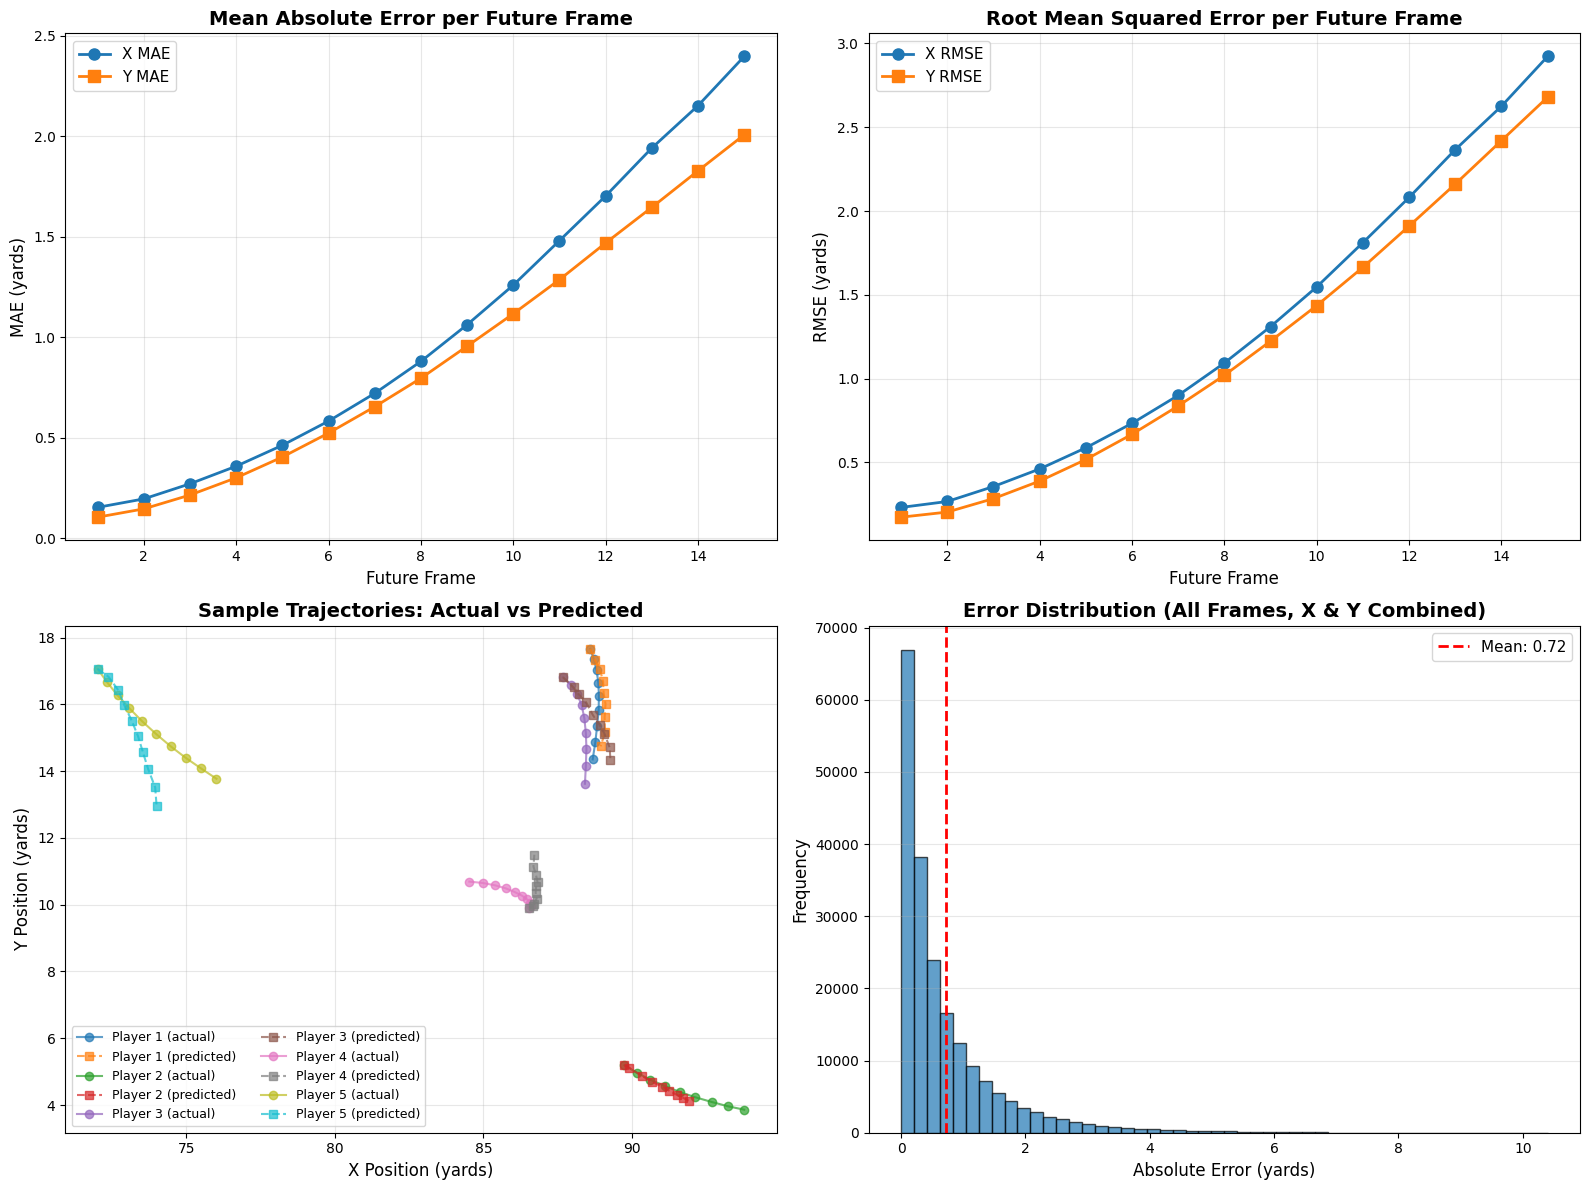

✓ Visualizations complete

TRAJECTORY PREDICTION COMPLETE

TEST EVALUATION SUMMARY
Test samples: 9217
Overall X MAE: 1.0415 yards
Overall Y MAE: 0.8970 yards
Overall X RMSE: 1.2861 yards
Overall Y RMSE: 1.1723 yards


In [15]:
# Test the prediction function on the test dataset
print("Testing the sequential prediction function on test data...")
print("="*80)

# Use the test datasets we prepared earlier
# df_test_X: input features (no output frames)
# df_test_y_true: ground truth output frames (x_1:x_15, y_1:y_15)

# Split ground truth into x and y components
x_true_cols = [f'x_{i}' for i in range(1, 16)]
y_true_cols = [f'y_{i}' for i in range(1, 16)]

df_test_y_true_x = df_test_y_true[x_true_cols]
df_test_y_true_y = df_test_y_true[y_true_cols]

# Make predictions with evaluation
test_predictions, test_metrics = predict_full_trajectory(
    df_input=df_test_X,
    df_true_x=df_test_y_true_x,
    df_true_y=df_test_y_true_y,
    plot_results=True,
    sample_trajectories=5
)

print("\n" + "="*80)
print("TEST EVALUATION SUMMARY")
print("="*80)
print(f"Test samples: {len(test_predictions)}")
print(f"Overall X MAE: {test_metrics['overall_mae_x']:.4f} yards")
print(f"Overall Y MAE: {test_metrics['overall_mae_y']:.4f} yards")
print(f"Overall X RMSE: {test_metrics['overall_rmse_x']:.4f} yards")
print(f"Overall Y RMSE: {test_metrics['overall_rmse_y']:.4f} yards")


Testing the sequential prediction function on test data...
PREDICTING FULL TRAJECTORY
Input samples: 9217

Predicting X positions (x_1 to x_15)...
  ✓ Predicted x_1 (min=12.72, max=117.99, mean=66.62)
  ✓ Predicted x_5 (min=12.63, max=118.52, mean=67.44)
  ✓ Predicted x_10 (min=13.43, max=118.62, mean=68.22)
  ✓ Predicted x_15 (min=23.34, max=118.54, mean=69.11)

Predicting Y positions (y_1 to y_15)...
  ✓ Predicted y_1 (min=2.26, max=50.59, mean=26.46)
  ✓ Predicted y_5 (min=1.42, max=51.06, mean=26.43)
  ✓ Predicted y_10 (min=1.23, max=51.35, mean=26.43)
  ✓ Predicted y_15 (min=1.14, max=51.79, mean=26.45)

✓ Prediction complete! Shape: (9217, 30)

EVALUATION METRICS

Overall X MAE: 1.0415 yards
Overall Y MAE: 0.8970 yards
Overall X RMSE: 1.2861 yards
Overall Y RMSE: 1.1723 yards

Per-frame X MAE:
  Frame  1: 0.1532 yards
  Frame  2: 0.1954 yards
  Frame  3: 0.2706 yards
  Frame  4: 0.3581 yards
  Frame  5: 0.4623 yards
  Frame  6: 0.5826 yards
  Frame  7: 0.7208 yards
  Frame  8: 0.

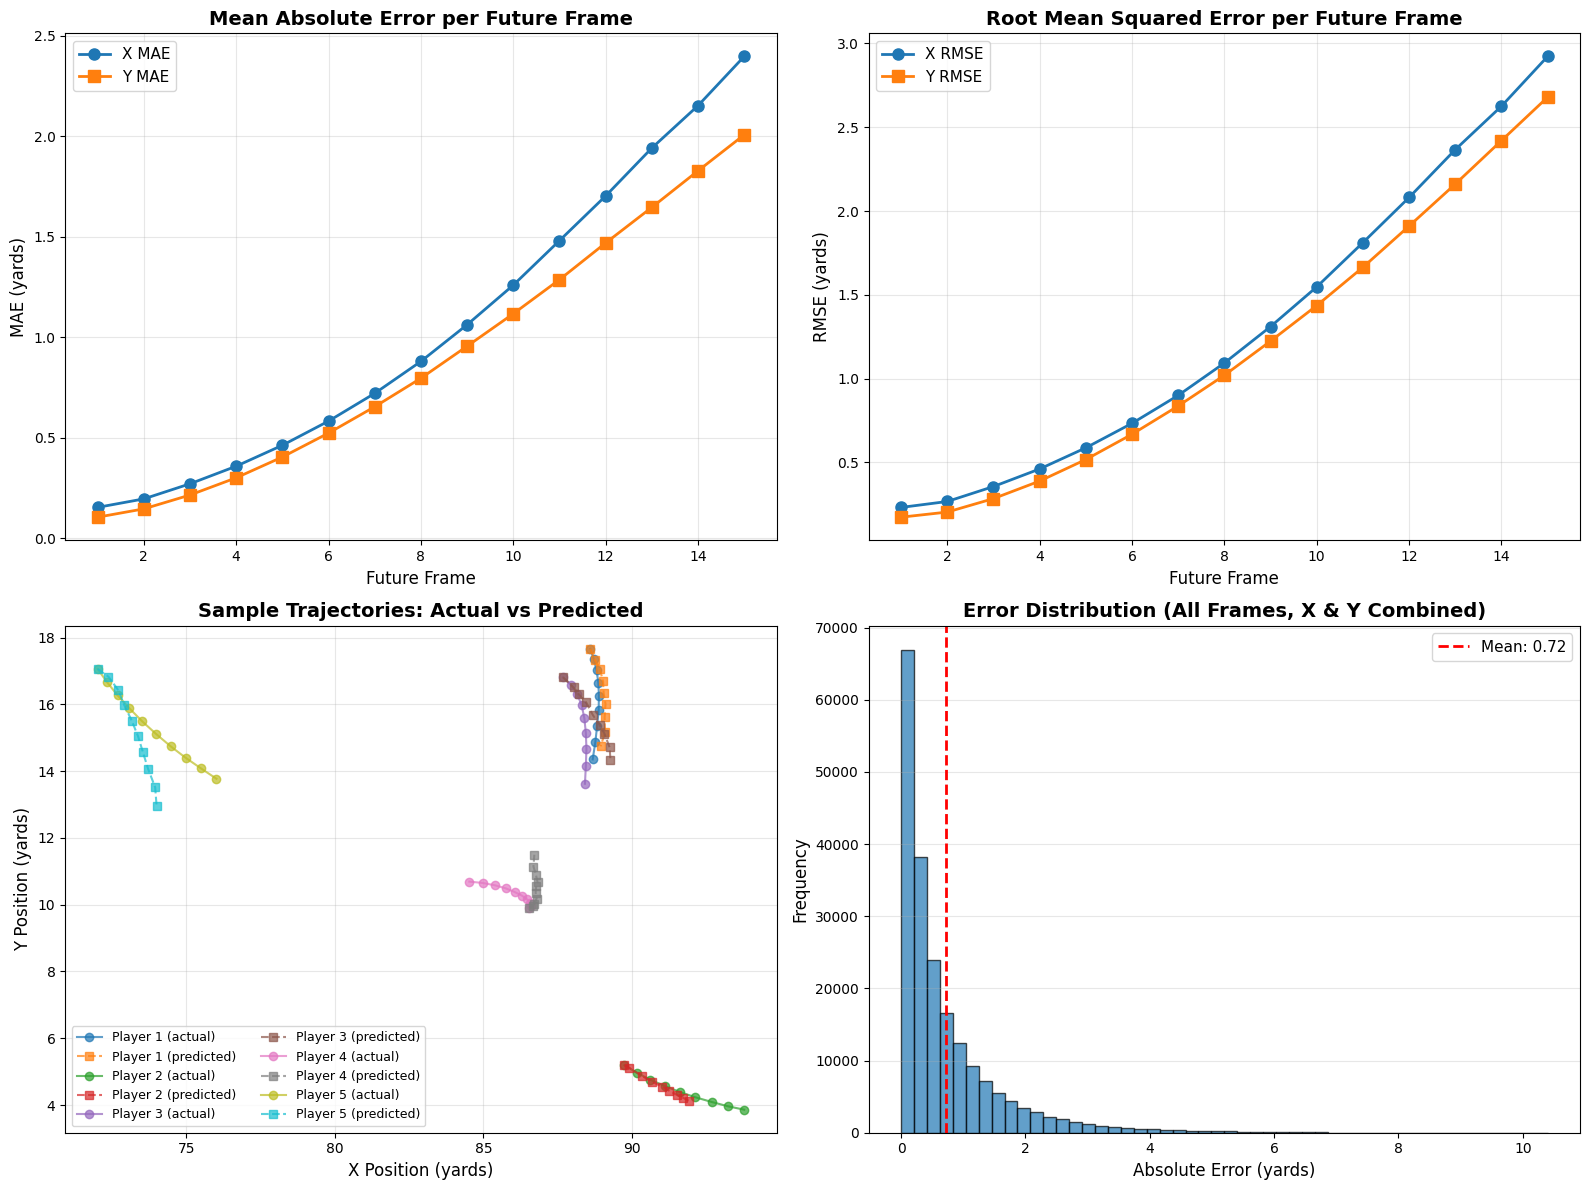

✓ Visualizations complete

TRAJECTORY PREDICTION COMPLETE

TEST EVALUATION SUMMARY
Test samples: 9217
Overall X MAE: 1.0415 yards
Overall Y MAE: 0.8970 yards
Overall X RMSE: 1.2861 yards
Overall Y RMSE: 1.1723 yards


In [16]:
# Test the prediction function on the test dataset
print("Testing the sequential prediction function on test data...")
print("="*80)

# Use the test datasets we prepared earlier
# df_test_X: input features (no output frames)
# df_test_y_true: ground truth output frames (x_1:x_15, y_1:y_15)

# Split ground truth into x and y components
x_true_cols = [f'x_{i}' for i in range(1, 16)]
y_true_cols = [f'y_{i}' for i in range(1, 16)]

df_test_y_true_x = df_test_y_true[x_true_cols]
df_test_y_true_y = df_test_y_true[y_true_cols]

# Make predictions with evaluation
test_predictions, test_metrics = predict_full_trajectory(
    df_input=df_test_X,
    df_true_x=df_test_y_true_x,
    df_true_y=df_test_y_true_y,
    plot_results=True,
    sample_trajectories=5
)

print("\n" + "="*80)
print("TEST EVALUATION SUMMARY")
print("="*80)
print(f"Test samples: {len(test_predictions)}")
print(f"Overall X MAE: {test_metrics['overall_mae_x']:.4f} yards")
print(f"Overall Y MAE: {test_metrics['overall_mae_y']:.4f} yards")
print(f"Overall X RMSE: {test_metrics['overall_rmse_x']:.4f} yards")
print(f"Overall Y RMSE: {test_metrics['overall_rmse_y']:.4f} yards")
